In [1]:
import pandas as pd 
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import os


os.chdir('../Dataset')
path = os.getcwd()


columns = ['class','l_shoulder','r_shoulder','l_arm','r_arm','l_hip','r_hip','l_knee','r_knee']

Y82_test = pd.read_csv(os.path.join(path,'Y82_testing_new.csv'), header=None)
Y82_train = pd.read_csv(os.path.join(path,'Y82_training_new.csv'), header=None)

L_test = pd.read_csv(os.path.join(path,'L_testing_new.csv'), header=None)
L_train = pd.read_csv(os.path.join(path,'L_training_new.csv'), header=None)

W2_test = pd.read_csv(os.path.join(path,'W2_testing_new.csv'), header=None)
W2_train = pd.read_csv(os.path.join(path,'W2_training_new.csv'), header=None)

combined_test = pd.concat([L_test, Y82_test, W2_test])
combined_train = pd.concat([L_train, Y82_train, W2_train])

combined_test.columns = columns 
combined_train.columns = columns 

combined_test['class'], classes = pd.factorize(combined_test['class'])
combined_train['class'], _ = pd.factorize(combined_train['class'])

''' Filtering out all the extra examples for the cobra class to make a more balanced data set '''
extra_test_cobra_rows = combined_test[combined_test['class'] == 1].sample(130)
extra_train_cobra_rows = combined_train[combined_train['class'] == 1].sample(275)

combined_test = combined_test.drop(extra_test_cobra_rows.index)
combined_train = combined_train.drop(extra_train_cobra_rows.index)

classes = list(classes)

In [2]:
for i, c in enumerate(classes):
    print(f"Train: {c} - {len(combined_train[combined_train['class'] == i])}")
    print(f"Test: {c} - {len(combined_test[combined_test['class'] == i])}")

Train: Tree - 368
Test: Tree - 113
Train: Cobra - 308
Test: Cobra - 118
Train: Chair - 320
Test: Chair - 141
Train: DownDog - 289
Test: DownDog - 98
Train: WarriorII - 384
Test: WarriorII - 140


In [4]:
all_combined_df = pd.concat([Y82_train, Y82_test, L_test, L_train, W2_train, W2_test])
all_combined = pd.concat([combined_test, combined_train])

def split_features_labels(df):
    return df.drop('class', axis=1), df['class']

# Random Forest Classifer
# 88-89% Maybe 90?
## IDK anymore.. even this is at like 95% lol

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       113
           1       0.94      0.95      0.95       118
           2       0.95      0.89      0.92       141
           3       0.98      0.96      0.97        98
           4       0.95      0.99      0.97       140

    accuracy                           0.95       610
   macro avg       0.95      0.95      0.95       610
weighted avg       0.95      0.95      0.95       610



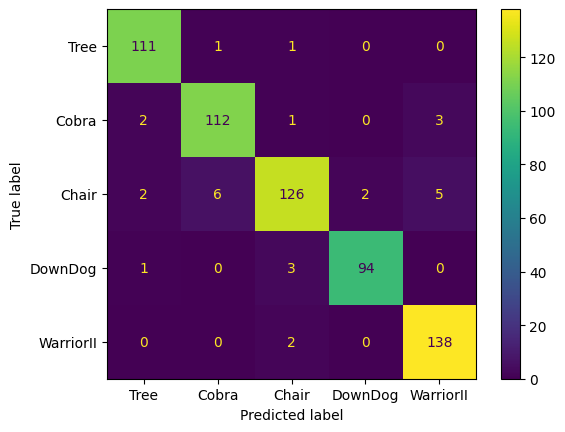

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
# from sklearn.model_selection import train_test_split // Don't need anymore

RANDOM_ORDER_DATA = True 
MAX_ESTIMATORS = 100
MAX_DEPTH = 8 

if RANDOM_ORDER_DATA:
  mutated_train = combined_train.sample(frac=1)
else:
  mutated_train = combined_train

X_train, y_train = split_features_labels(mutated_train)
X_test, y_test = split_features_labels(combined_test)


forest_classifier = RandomForestClassifier()
param_grid = {'n_estimators' : np.arange(1, MAX_ESTIMATORS),
              'max_depth' : np.arange(1, MAX_DEPTH),
            }

forest_classifier_gscv = RandomizedSearchCV(forest_classifier, param_distributions=param_grid, cv=5, n_jobs=-1)

#fit model to data
forest_classifier_gscv.fit(X_train, y_train)

MAX_DEPTH = forest_classifier_gscv.best_params_['max_depth']
N_ESTIMATORS = forest_classifier_gscv.best_params_['n_estimators']

best_forest = RandomForestClassifier(max_depth=MAX_DEPTH, n_estimators=N_ESTIMATORS)
best_forest.fit(X_train, y_train)

pred = best_forest.predict(X_test)
cm = confusion_matrix(y_test, pred)
display_confusion_matrix = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
display_confusion_matrix.plot()
print(classification_report(y_test, pred))

# KNN Classifer 
# Eh Around 88%


Fitted KNN Classifer with ALGORITHM='kd_tree' and N_NEIGHBORS=3
              precision    recall  f1-score   support

           0       0.93      0.98      0.95       113
           1       0.96      0.95      0.95       118
           2       0.96      0.92      0.94       141
           3       0.99      0.98      0.98        98
           4       0.97      0.97      0.97       140

    accuracy                           0.96       610
   macro avg       0.96      0.96      0.96       610
weighted avg       0.96      0.96      0.96       610



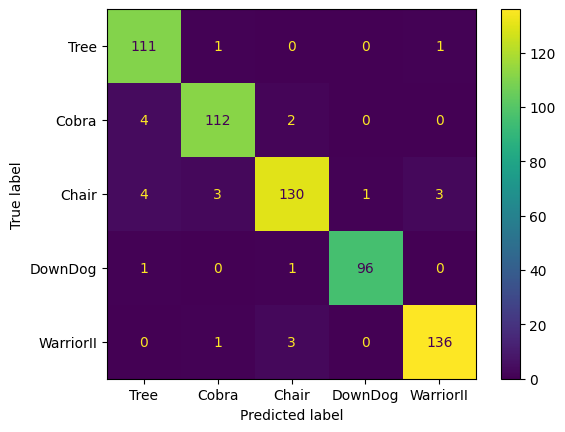

In [12]:
# Grid searching best hyper params 
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier as KNN 

''' Don't need to do this anymore, cause the dataset is already split (Didn't realise this) '''
# from sklearn.model_selection import train_test_split
# 80/20 Split of data, Doesn't randomize, Randomsplit ensures the proportion of classes is the same. 
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
RANDOM_ORDER_DATA = True 



'''Shuffle data for better resuliting'''
if RANDOM_ORDER_DATA:
    mutated_train = combined_train.sample(frac=1)
else:
    mutated_train = combined_train

X_train, y_train = split_features_labels(mutated_train)
X_test, y_test = split_features_labels(combined_test)

max_neighbours = int(np.sqrt(len(X_train)))
knn_algorithms = ['kd_tree', 'brute', 'ball_tree']


knn = KNN()

param_grid = {'n_neighbors' : np.arange(1, max_neighbours),
              'algorithm' : knn_algorithms}

# Using grid search cross validation to find the best value of K 
knn_gscv = GridSearchCV(knn, param_grid, cv=5, n_jobs=-1)

knn_gscv.fit(X_train, y_train)

ALGORITHM = knn_gscv.best_params_['algorithm']
N_NEIGHBORS = knn_gscv.best_params_['n_neighbors']

best_KNN = KNN(algorithm=ALGORITHM, n_neighbors=N_NEIGHBORS)
best_KNN.fit(X_train, y_train)

print(f"Fitted KNN Classifer with {ALGORITHM=} and {N_NEIGHBORS=}")


pred = best_KNN.predict(X_test)
cm = confusion_matrix(y_test, pred)
display_confusion_matrix = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
display_confusion_matrix.plot()
print(classification_report(y_test, pred))

# NN Classifier
## About 87-89% Acc - okay
## WOW WITH JUST A BIT OF DATACLEANING, GETTING SOME MORE EXAMPLES AND FIXING A BUG THE ACCURACY SHOT UP - 94% 

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV

'''Shuffle data for better resuliting'''
RANDOM_ORDER_DATA = True 
if RANDOM_ORDER_DATA:
    mutated_train = combined_train.sample(frac=1)
else:
    mutated_train = combined_train

X_train, y_train = split_features_labels(mutated_train)
X_test, y_test = split_features_labels(combined_test)

# Define the parameter distributions to sample from
param_dist = {
    'hidden_layer_sizes' : [(i, j) for i in range(1, 15) for j in range(1, 15)],
    'solver': ['adam', 'lbfgs'],
    'activation': ['relu', 'logistic'],
    'alpha' : [0.0001, 0.0001, 0.00005]
}

# Initialize MLPClassifier with default values
mlp = MLPClassifier(max_iter=10000)

random_search = RandomizedSearchCV(mlp, param_distributions=param_dist, n_iter=100, cv=5, n_jobs=-1)

# Train the classifier on your data
random_search.fit(X_train, y_train)

# Get the best hyperparameters from the search
best_params = random_search.best_params_
print("Best solver: ", best_params['solver'])
print("Best activation: ", best_params['activation'])
print("Layers: ", best_params['hidden_layer_sizes'] )
print("Alpha: ", best_params['alpha'])

# Use the best hyperparameters to initialize the MLPClassifier
best_mlp = MLPClassifier(solver=best_params['solver'], activation=best_params['activation'], alpha=best_params['alpha'], hidden_layer_sizes=best_params['hidden_layer_sizes'], max_iter=1000)

# Train the MLPClassifier on the training data
best_mlp.fit(X_train, y_train)



In [7]:
print("Best solver: ", best_params['solver'])
print("Best activation: ", best_params['activation'])
print("Layers: ", best_params['hidden_layer_sizes'] )
print("Alpha: ", best_params['alpha'])


Best solver:  adam
Best activation:  relu
Layers:  (11, 14)
Alpha:  0.0001


              precision    recall  f1-score   support

           0       0.95      0.98      0.97       113
           1       0.95      0.90      0.93       118
           2       0.96      0.85      0.90       141
           3       0.97      0.99      0.98        98
           4       0.89      0.99      0.94       140

    accuracy                           0.94       610
   macro avg       0.94      0.94      0.94       610
weighted avg       0.94      0.94      0.94       610



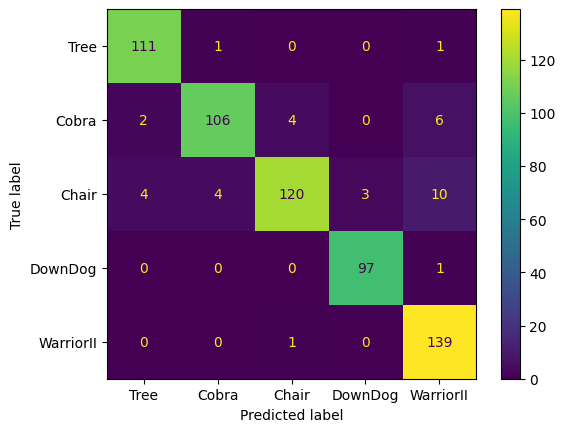

In [8]:
# Use the best hyperparameters to initialize the MLPClassifier
best_mlp = MLPClassifier(solver=best_params['solver'], activation=best_params['activation'], alpha=best_params['alpha'], hidden_layer_sizes=best_params['hidden_layer_sizes'], max_iter=1000)

# Train the MLPClassifier on the training data
best_mlp.fit(X_train, y_train)

pred = best_mlp.predict(X_test)
cm = confusion_matrix(y_test, pred)
display_confusion_matrix = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
display_confusion_matrix.plot()
print(classification_report(y_test, pred))

# SVC Grid Search Classifer
## Consistent 90% Sometimes 91%
## After replacing Warrior3 for Warrior2 (Is a hard pose to do, and W3 had too much overlap with the other classes + fixing a 20degree error in the pre-processing the accuracy gained went up by 5% !!)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END ................C=0.1, gamma=scale;, score=0.853 total time=   0.1s
[CV 2/5] END ................C=0.1, gamma=scale;, score=0.901 total time=   0.1s
[CV 3/5] END ................C=0.1, gamma=scale;, score=0.880 total time=   0.1s
[CV 4/5] END ................C=0.1, gamma=scale;, score=0.886 total time=   0.1s
[CV 5/5] END ................C=0.1, gamma=scale;, score=0.871 total time=   0.1s
[CV 1/5] END ..................C=1, gamma=scale;, score=0.883 total time=   0.0s
[CV 2/5] END ..................C=1, gamma=scale;, score=0.931 total time=   0.0s
[CV 3/5] END ..................C=1, gamma=scale;, score=0.892 total time=   0.0s
[CV 4/5] END ..................C=1, gamma=scale;, score=0.919 total time=   0.0s
[CV 5/5] END ..................C=1, gamma=scale;, score=0.904 total time=   0.0s
[CV 1/5] END ..................C=5, gamma=scale;, score=0.892 total time=   0.0s
[CV 2/5] END ..................C=5, gamma=scale;,

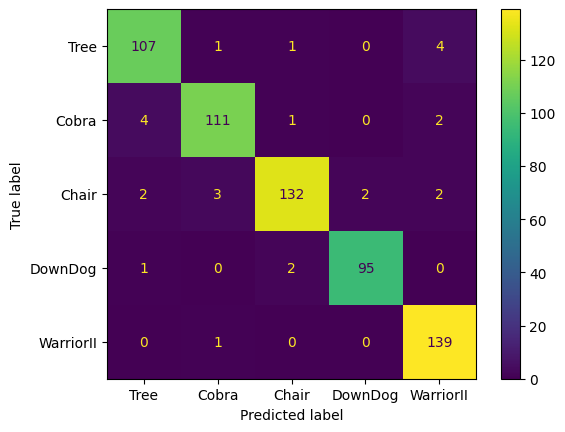

In [5]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.svm import SVC

RANDOM_ORDER_DATA = True 
RANDOM_CV = False

'''Shuffle data for better resuliting'''
if RANDOM_ORDER_DATA:
    mutated_train = combined_train.sample(frac=1)
else:
    mutated_train = combined_train

X_train, y_train = split_features_labels(mutated_train)
X_test, y_test = split_features_labels(combined_test)

svm = SVC(kernel='rbf') 


'''Tried search for gamma manually but it appears using scale is just better''' 
n_features = X_train.shape[1]
gamma_start = 1 / (n_features * max(X_train.var()))
gamma_step = 0.005
gamma_end = gamma_start + (10 * gamma_step)

### Doing Grid Search Now ###

gamma_range = np.arange(gamma_start, gamma_end, gamma_step)
C_range = [0.1, 1, 5, 10]
# set the parameter grid for grid search
param_grid = {
        'C': C_range,
        'gamma' : ['scale']
    }

# perform grid search
if RANDOM_CV:
    grid = RandomizedSearchCV(svm, cv=5, param_distributions=param_grid, verbose=3)
else:
    grid = GridSearchCV(svm, cv=5, param_grid=param_grid, verbose=3)
grid.fit(X_train, y_train)

# best parameters and score
print("Best parameters:", grid.best_params_)
print("Best Score: ", grid.best_score_)

best_svc = SVC(kernel='rbf', C=grid.best_params_['C'], gamma=grid.best_params_['gamma'], probability=True)

best_svc.fit(X_train, y_train)

''' Plotting '''

pred = best_svc.predict(X_test)
cm = confusion_matrix(y_test, pred)
display_confusion_matrix = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
display_confusion_matrix.plot()
print(classification_report(y_test, pred))

# Video & Classifer Integration

In [13]:
import cv2
import mediapipe as mp
import numpy as np
import time 

mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

MIN_DETECTION_CONFIDENCE = 0.5
MIN_TRACKING_CONFIDENCE = 0.5

# All landmark except for hand and face specific
RelevantLandmarks = list(mp_pose.PoseLandmark)[11:17] + list(mp_pose.PoseLandmark)[23:29]

l_hip_landmark_angle_idx = (11,23,25)
r_hip_landmark_angle_idx = (12,24,26)

l_shoulder_landmark_angle_idx = (13,11,23)
r_shoulder_landmark_angle_idx = (14,12,24)

l_arm_landmark_angle_idx = (15,13,11)
r_arm_landmark_angle_idx = (16,14,12)

l_knee_landmark_angle_idx = (23,25,27)
r_knee_landmark_angle_idx = (24,26,28)

#Match idx of RelevantLandmarks 
angle_idxs_required = [
    l_shoulder_landmark_angle_idx,
    r_shoulder_landmark_angle_idx,
    
    l_arm_landmark_angle_idx,
    r_arm_landmark_angle_idx,
    
    l_hip_landmark_angle_idx,
    r_hip_landmark_angle_idx,
    
    l_knee_landmark_angle_idx,
    r_knee_landmark_angle_idx
]
skip_landmark = {
    mp_pose.PoseLandmark.RIGHT_ANKLE,
    mp_pose.PoseLandmark.LEFT_ANKLE,
    mp_pose.PoseLandmark.RIGHT_WRIST,
    mp_pose.PoseLandmark.LEFT_WRIST
}

In [14]:
landmarkStr = {
    mp_pose.PoseLandmark.NOSE : "NOSE",
    mp_pose.PoseLandmark.LEFT_EYE_INNER : "LEFT_EYE_INNER",
    mp_pose.PoseLandmark.LEFT_EYE : "LEFT_EYE",
    mp_pose.PoseLandmark.LEFT_EYE_OUTER : "LEFT_EYE_OUTER",
    mp_pose.PoseLandmark.RIGHT_EYE_INNER : "RIGHT_EYE_INNER",
    mp_pose.PoseLandmark.RIGHT_EYE : "RIGHT_EYE",
    mp_pose.PoseLandmark.RIGHT_EYE_OUTER : "RIGHT_EYE_OUTER",
    mp_pose.PoseLandmark.LEFT_EAR : "LEFT_EAR",
    mp_pose.PoseLandmark.RIGHT_EAR : "RIGHT_EAR",
    mp_pose.PoseLandmark.MOUTH_LEFT : "MOUTH_LEFT",
    mp_pose.PoseLandmark.MOUTH_RIGHT : "MOUTH_RIGHT",
    mp_pose.PoseLandmark.LEFT_SHOULDER : "LEFT_SHOULDER",
    mp_pose.PoseLandmark.RIGHT_SHOULDER : "RIGHT_SHOULDER",
    mp_pose.PoseLandmark.LEFT_ELBOW : "LEFT_ELBOW",
    mp_pose.PoseLandmark.RIGHT_ELBOW : "RIGHT_ELBOW",
    mp_pose.PoseLandmark.LEFT_WRIST : "LEFT_WRIST",
    mp_pose.PoseLandmark.RIGHT_WRIST : "RIGHT_WRIST",
    mp_pose.PoseLandmark.LEFT_PINKY : "LEFT_PINKY",
    mp_pose.PoseLandmark.RIGHT_PINKY : "RIGHT_PINKY",
    mp_pose.PoseLandmark.LEFT_INDEX : "LEFT_INDEX",
    mp_pose.PoseLandmark.RIGHT_INDEX : "RIGHT_INDEX",
    mp_pose.PoseLandmark.LEFT_THUMB : "LEFT_THUMB",
    mp_pose.PoseLandmark.RIGHT_THUMB : "RIGHT_THUMB",
    mp_pose.PoseLandmark.LEFT_HIP : "LEFT_HIP",
    mp_pose.PoseLandmark.RIGHT_HIP : "RIGHT_HIP",
    mp_pose.PoseLandmark.LEFT_KNEE : "LEFT_KNEE",
    mp_pose.PoseLandmark.RIGHT_KNEE : "RIGHT_KNEE",
    mp_pose.PoseLandmark.LEFT_ANKLE : "LEFT_ANKLE",
    mp_pose.PoseLandmark.RIGHT_ANKLE : "RIGHT_ANKLE",
    mp_pose.PoseLandmark.LEFT_HEEL : "LEFT_HEEL",
    mp_pose.PoseLandmark.RIGHT_HEEL : "RIGHT_HEEL",
    mp_pose.PoseLandmark.LEFT_FOOT_INDEX : "LEFT_FOOT_INDEX",
    mp_pose.PoseLandmark.RIGHT_FOOT_INDEX : "RIGHT_FOOT_INDEX"
}

def calc_angle(a, b, c):
    a = np.array(a)
    b = np.array(b)    
    c = np.array(c)   
    
    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(radians*180.0/np.pi)
    
    if angle > 180.0:
        angle = 360-angle
    
    return angle 

In [15]:
def classify_pose(example, classifer):
    example = pd.DataFrame(np.array(example).reshape(1, -1), columns=columns[1:])
    

    if classifer == 'KNN':
        probabilty_classes = best_KNN.predict_proba(example)
    elif classifer == 'Forest':
        probabilty_classes = best_forest.predict_proba(example)
    elif classifer == 'SVM':
        probabilty_classes = best_svc.predict_proba(example)
    elif classifer == 'NN':
        probabilty_classes = best_mlp.predict_proba(example)
    else:
        raise Exception("Please enter valid classifer. Currently only ('KNN' | 'Forest' | 'NN' | 'SVM')")

    
    prob_predicted_classes = [] 
    for class_idx, prob in enumerate(probabilty_classes[0]):
        prob_predicted_classes.append((classes[class_idx], prob))
        
    prob_predicted_classes.sort(key = lambda x: x[1], reverse=True)
    
    # Get the highest predicted class 
    predicted_class = prob_predicted_classes[0]
    
    return (predicted_class, sorted(prob_predicted_classes, key = lambda x: x[1], reverse=True))

# Sanity test classification 
classify_pose([8.390697637127042, 13.364568331384618, 16.49759248897499, 153.50000646379374, 173.20291493738577, 199.52935190007366, 179.00845878279233, 198.25172013734928], classifer='SVM')

(('WarriorII', 0.810869556736833),
 [('WarriorII', 0.810869556736833),
  ('Cobra', 0.15865298567583103),
  ('DownDog', 0.014428509063708676),
  ('Tree', 0.01426943849850473),
  ('Chair', 0.0017795100251228023)])

In [16]:
def unnormalize_cords(x, y, fw, fh):
    return tuple(np.multiply([x, y], [fw, fh]).astype(int))

In [17]:
CLASSIFIER = 'SVM'
import traceback

# Create two windows to display the images
# cv2.namedWindow("Real Image", cv2.WINDOW_NORMAL)
# cv2.namedWindow("Pose Skeleton", cv2.WINDOW_NORMAL)
last_class = ''
MIN_DETECTION_CONFIDENCE = 0.5
MIN_TRACKING_CONFIDENCE = 0.5
VERBOSE = False
EXAMPLE_POSE_IMAGE = {i.replace('.jpeg', '') : cv2.imread(f"../DemoImages/{i}", 1) for i in os.listdir("../DemoImages")}

''' Using the media pose model'''
with mp_pose.Pose(min_detection_confidence=MIN_DETECTION_CONFIDENCE, min_tracking_confidence=MIN_TRACKING_CONFIDENCE, static_image_mode=False) as pose:
    '''
        Capturing webcam footage 
    '''
    cap = cv2.VideoCapture(0) # this is the magic!

    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)
    
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    while cap.isOpened():
        suc, frame = cap.read() 
        if not suc:
            print("Frame empty..")
            continue 
        
        #Recolor image 
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
        
        # Make detections 
        results = pose.process(image=image)
        pose_landmarks = results.pose_landmarks
        try: 

            ''' Converting landmarks into angles'''
            pose_relevant_landmark_angles = []
            # Going through all relevant landmarks, extracting their key angles
            # Calculating the angle then adding to array 
            for i1, i2, i3 in angle_idxs_required:
                
                fst = (pose_landmarks.landmark[i1].x, pose_landmarks.landmark[i1].y)
                snd = (pose_landmarks.landmark[i2].x, pose_landmarks.landmark[i2].y)
                thrd = (pose_landmarks.landmark[i3].x, pose_landmarks.landmark[i3].y)
                
                
                pose_relevant_landmark_angles.append(calc_angle(fst, snd, thrd))
                
            # Getting cords of the landmarks FOR ANGLES WE CALC'D CORDS FOR. 
            # If any any of this landamrks have a visbility < MIN_DETECTION_CONFIDENCE. 
            # Display an error / throw an error saying you need the whole body in the frame
            pose_relevant_landmark_cords = [] 
            for _, idx, _ in angle_idxs_required:
                if idx in skip_landmark:
                    continue
                
                current_landmark = pose_landmarks.landmark[idx]
                
                # if current_landmark.visibilty < MIN_DETECTION_CONFIDENCE:
                #     raise Exception("Whole body not visible. Put the whole body in the frame for accurate yoga pose detection.") 
                
                pose_relevant_landmark_cords.append([current_landmark.x, current_landmark.y])
                
            
            pose_relevant_landmark_angles_visual = np.around(pose_relevant_landmark_angles, 2).astype(str).tolist()
            
            ''' CLASSIFICATION OF POSE''' 
            predicted_pose, prob_predictions = classify_pose(pose_relevant_landmark_angles, CLASSIFIER)
            
            ''' Pose Threshold'''

            if (predicted_pose[1] >= 0.80):
                if last_class != predicted_pose[0]:
                    last_class = predicted_pose[0]
                    if VERBOSE:
                        print(predicted_pose)
            else:
                if last_class != 'Unknown':
                    last_class = 'Unknown'
                    if VERBOSE:
                        print("No Pose Detected")
                        
                if VERBOSE:
                    print(f'PROBAS: {prob_predictions}')

            ''' First Window '''
            #Revert image color 
            image.flags.writeable = True 
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

            #Render detections 
            mp_drawing.draw_landmarks(
                image, 
                results.pose_landmarks, 
                mp_pose.POSE_CONNECTIONS,
                mp_drawing.DrawingSpec(color=(50, 145, 168), circle_radius=2, thickness=2),
                mp_drawing.DrawingSpec(color=(209, 192, 42), circle_radius=2, thickness=2)
            )
            
            if last_class == 'Unknown':
                display_text = 'Unknown'
            else:
                display_text = f'{last_class} - {predicted_pose[1]:.2f}%'
            
            cv2.putText(image, display_text, unnormalize_cords(0.4, 0.1, frame_width, frame_height), cv2.FONT_HERSHEY_SIMPLEX, 2, (125, 0, 0), 2, cv2.LINE_AA) 
            ''' ---- '''
            
            ''' Second Window '''
            black_image = np.zeros((frame_height, frame_width, 3), np.uint8)

            # Render detections on the black image
            mp_drawing.draw_landmarks(
                black_image, 
                results.pose_landmarks,
                mp_pose.POSE_CONNECTIONS,                
                mp_drawing.DrawingSpec(color=(50, 145, 168), circle_radius=2, thickness=2),
                mp_drawing.DrawingSpec(color=(209, 192, 42), circle_radius=2, thickness=2)
            )

            
            # Write the joint angles on the black image
            for i, angle in enumerate(pose_relevant_landmark_angles_visual):
                x, y = pose_relevant_landmark_cords[i]
                cv2.putText(black_image, angle, unnormalize_cords(x, y, frame_width, frame_height), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA)
            ''' ---- '''
            
            ''' Third Window '''
            correct_example_image = cv2.resize(EXAMPLE_POSE_IMAGE[last_class], (frame_width, frame_height))

            # old_height, old_width, _ = correct_example_image.shape 
            # aspect_ratio = old_height / 20 
            
            # new_height = int(old_width * aspect_ratio)
            
            # resized_example_image = cv2.resize(correct_example_image, (old_width, new_height), interpolation = cv2.INTER_AREA)
            
            ''' ---- '''
                        
            # Display the two images side by side
            result = np.concatenate((image, black_image, correct_example_image), axis=1)
            
            cv2.imshow("Image & Skele", result)

        except Exception:
            # print('Exception Caught:')
            traceback.print_exc()

        # Closing the video capture  
        if cv2.waitKey(1) & 0xFF == ord('w'):
            break
    
    
cap.release() 
cv2.destroyAllWindows()

FileNotFoundError: [Errno 2] No such file or directory: '../DemoImages'